In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## to do
1. Sneaker Name 별로 Order Date가 중복되는 경우 있는지 체크. -> 존재한다면 해당 Order Date의 Sale Price는 평균값으로 대체하기 ==> 2022.01.11 완료
2. 각 변수별로 간단한 설명 직접 써보고, 어떤 Information을 얻을 수 있을지 고찰해보기 ==> 2022.01.12 진행 중
3. Sneaker Name 별로: 만약 Order Date가 2022-01-17이라면 해당 일자의 Date Avg Sale Price와 전일(2022-01-16)의 Date Avg Sale Price 변화량 변수 추가

## 새롭게 써 본 메소드나 파이썬 문법 관련 및 좀 더 공부가 필요하다고 판단되는 것들
1. groupby(), aggregate()
2. **데이터 시각화**!!! 간단한 분석 내용 도출이나 새로운 분석을 위한 아이디어를 얻을 때 아주 중요하구나!!

## Description of Data
---
The data in this sheet consist of a random sample of all U.S. Off-White x Nike and Yeezy 350 sales from between 9/1/2017 and 2/13/2019. 

To create this sample, we took a ***random, fixed percentage of StockX sales (X%) for each colorway, on each day***, since September, 2017. So, for each day the Off-White Jordan 1 was on the market, we randomly selected X% of its sale from each day. (It’s not important to know what X is; all that matters is that it’s a random sample, and that the same fixed X% of sales was selected from every day, for every sneaker). The sample was limited to U.S. sales only.

We’ve included 8 variables for you to work with: Order Date, Brand, Sneaker Name, Sale Price (dollar), Retail Price (dollar), Release Date, Shoe Size, and Buyer Region (the state the buyer shipped to). You can use whatever variables you want in the analysis; you can use 1 variable, or you can use all 8. 

## 변수 설명 및 분석 아이디어 도출
---
### 변수 설명
- Order Date: 신발 주문 일자 (StockX에서 특정 신발의 거래가 체결된 일자)
- Brand: Yeezy, Off-White
- Sale Price: 리셀된 가격
- Retail Price: 정가
- Release Date: 발매 일자
- Shoe Size: 신발 US Size => 전처리로 mm size로 변환했음
- Buyer Region: 구매자가 신발을 배송받은 지역(주)
- Date Avg Sale Price(전처리로 만든 변수): 각 Sneaker Name의 Order Date별 평균 Sale Price
---
### 분석 아이디어 도출
#### 시각화 통한 분석
- Brand 별 Sale Price 분석
- Shoe Size 별 Sale Price 분석
- Buyer Region 별 Sale Price 분석
- Retail Price와 Sale Price 관계 분석
- Release Date와 Sale Price 관계 분석

#### 예측 모델 수립을 통한 분석
- Sneaker Name 별로 미래 Sale Price Regression (선행 프로젝트 보면 시계열 분석을 한 게 아니라서 시계열 정보 포함해서 Regression 모델 만들어보기)
- 

- 선행 프로젝트
---
1. stockx 동일한 데이터 이용한 프로젝트(Price Regression): https://ichi.pro/ko/meosin-leoning-eulo-stockx-undonghwa-gagyeog-yecheug-260157814980288
2. stockx 동일한 데이터 이용한 프로젝트(Price Regression): https://www.kaggle.com/logannorman/stockx-sneaker-price-regression
3. 머신 러닝 기법을 활용한 한정판 운동화 리셀 여부 예측 및 수익성 평가 (서울대학교 대학원 석사 논문): https://s-space.snu.ac.kr/handle/10371/166432 
=> SVM, Random Forest, Ensemble 등의 머신러닝 기법을 이용해서 특정 한정판 신발의 "리셀 여부"(Binary Classification) 예측함


In [ ]:
# 패키지 불러오기
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기

In [ ]:
df_og = pd.read_excel('/content/drive/MyDrive/PersonalProject/sneakers/StockX-Data-Contest-2019-3.xlsx', sheet_name = 1)  # 원본 데이터 불러오기

In [ ]:
df = df_og.iloc[:,:]  # 원본 데이터 복사 => 분석용

In [ ]:
df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097.0,220,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685.0,220,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690.0,220,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075.0,220,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828.0,220,2017-02-11,11.0,Rhode Island


In [ ]:
# Sneaker Name 별로 오름차순으로 정렬 후, Sneaker Name 별로 Order Date 순서로 정렬
df = df.sort_values(by = ['Sneaker Name','Order Date'], ascending= True)
df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
112,2017-09-07,Yeezy,Adidas-Yeezy-Boost-350-Low-Moonrock,1230.0,200,2015-11-14,10.5,Michigan
588,2017-09-26,Yeezy,Adidas-Yeezy-Boost-350-Low-Moonrock,1257.0,200,2015-11-14,9.5,Nevada
764,2017-10-04,Yeezy,Adidas-Yeezy-Boost-350-Low-Moonrock,1000.0,200,2015-11-14,7.0,California
903,2017-10-12,Yeezy,Adidas-Yeezy-Boost-350-Low-Moonrock,1250.0,200,2015-11-14,6.5,California
919,2017-10-13,Yeezy,Adidas-Yeezy-Boost-350-Low-Moonrock,1250.0,200,2015-11-14,6.0,Florida


# 데이터 전처리

## 결측치 및 변수 형태, 기술 통계량 확인

In [ ]:
# 변수별 결측치 확인
np.sum(pd.isnull(df))

Order Date      0
Brand           0
Sneaker Name    0
Sale Price      0
Retail Price    0
Release Date    0
Shoe Size       0
Buyer Region    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99956 entries, 112 to 99955
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order Date    99956 non-null  datetime64[ns]
 1   Brand         99956 non-null  object        
 2   Sneaker Name  99956 non-null  object        
 3   Sale Price    99956 non-null  float64       
 4   Retail Price  99956 non-null  int64         
 5   Release Date  99956 non-null  datetime64[ns]
 6   Shoe Size     99956 non-null  float64       
 7   Buyer Region  99956 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 6.9+ MB


In [ ]:
# Numerical Variables 기술 통계량 확인
df.describe()

,Sale Price,Retail Price,Shoe Size
count,99956.000000,99956.00000,99956.000000
mean,446.634754,208.61359,9.344181
std,255.982918,25.20001,2.329588
min,186.000000,130.00000,3.500000
25%,275.000000,220.00000,8.000000
50%,370.000000,220.00000,9.500000
75%,540.000000,220.00000,11.000000
max,4050.000000,250.00000,17.000000


## 전처리

In [ ]:
# Brand column, Sneaker Name column 전처리
df['Brand'] = df['Brand'].apply(lambda x: x.replace(" ",""))  # 빈 스페이스 바 제거 (# 원래는 Yeezy 앞에 빈 스페이스 바가 있는 " Yeezy" 상태였음)
df['Sneaker Name'] = df['Sneaker Name'].apply(lambda x: x.replace('-',' ')) # Sneaker Name에 -를 스페이스 바로 대체
df.head(3)

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
112,2017-09-07,Yeezy,Adidas Yeezy Boost 350 Low Moonrock,1230.0,200,2015-11-14,10.5,Michigan
588,2017-09-26,Yeezy,Adidas Yeezy Boost 350 Low Moonrock,1257.0,200,2015-11-14,9.5,Nevada
764,2017-10-04,Yeezy,Adidas Yeezy Boost 350 Low Moonrock,1000.0,200,2015-11-14,7.0,California


In [ ]:
# Shoe Size(US) => Shoe Size(mm)로 바꾸기 (남자 신발 사이즈 기준으로 변환)
# Ex) US 3.5 Size => 215 (mm), US 9 Size => 270 (mm)

us_size = sorted(df['Shoe Size'].unique().tolist()) # 데이터에 15.5, 16.5 Size는 없음
mm_size = [(215 + 5*i) for i in range(len(us_size))]
mm_size[-2] = 340 
mm_size[-1] = 350

size_dict = {}
for us, mm in zip(us_size, mm_size):
  size_dict[us] = str(mm)

df['Shoe Size'] = df['Shoe Size'].replace(size_dict)

In [ ]:
# Order Date column 전처리
# Sneaker Name 별로 동일한 Order Date에 다른 Sale Price가 존재한다면 => 해당 Order Date의 평균 Sale Price로 값 대체하기
# Ex) 'Adidas Yeezy Boost 350 Low Moonrock'의 Order Date가 '2017-09-07'인 행이 3개 존재하고 각각 Sale Price가 1230.0, 1232.0, 1234.0이면 Order Date '2017-09-07'인 행에 새로운 변수를 만들어서 평균값인 1232를 입력
# => 한계점: Shoe Size와 Buyer Region을 고려하지 않음

# groupby 이용해서 일차적으로 파악
df.groupby(['Sneaker Name','Order Date']).aggregate([min, np.mean, max])['Sale Price']  # Sneaker Name과 Order Date 별로 Sale Price의 최소값, 평균값, 최대값 확인 => Sneaker 별로 동일한 Order Date에 다른 Sale Price 존재 확인

min  ...     max
Sneaker Name                                Order Date          ...        
Adidas Yeezy Boost 350 Low Moonrock         2017-09-07  1230.0  ...  1230.0
                                            2017-09-26  1257.0  ...  1257.0
                                            2017-10-04  1000.0  ...  1000.0
                                            2017-10-12  1250.0  ...  1250.0
                                            2017-10-13  1250.0  ...  1250.0
...                                                        ...  ...     ...
adidas Yeezy Boost 350 V2 Static Reflective 2019-02-09   328.0  ...   580.0
                                            2019-02-10   330.0  ...   625.0
                                            2019-02-11   338.0  ...   635.0
                                            2019-02-12   328.0  ...   675.0
                                            2019-02-13   335.0  ...   700.0

[10955 rows x 3 columns]

In [ ]:
names = df['Sneaker Name'].unique().tolist()  # Sneaker Name 리스트 생성

# Sneaker Name 별로 Order Date 별로 평균 Sale Price 값 산출해서 "Date Avg Sale Price" 변수 생성
list_of_df = []
df2 = pd.DataFrame()

for name in names:
  temp_df = df[df['Sneaker Name'] == name]
  temp_dates = temp_df.groupby('Order Date').mean()['Sale Price'].index.tolist()    
  temp_mean_sales = temp_df.groupby('Order Date').mean()['Sale Price'].values.tolist()  
  temp_df.set_index('Order Date',inplace = True)

  
  for date, mean_sale in zip(temp_dates, temp_mean_sales):
    temp_df.loc[temp_df.index == date,'Date Avg Sale Price'] = mean_sale

  temp_df.reset_index(inplace = True) 
  list_of_df.append(temp_df)

df2 = pd.concat(list_of_df, axis = 0)
df = df2.reset_index(drop = True)
df.tail(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Date Avg Sale Price
99953,2019-02-13,Yeezy,adidas Yeezy Boost 350 V2 Static Reflective,605.0,220,2018-12-26,235,New York,599.7343
99954,2019-02-13,Yeezy,adidas Yeezy Boost 350 V2 Static Reflective,650.0,220,2018-12-26,290,California,599.7343
99955,2019-02-13,Yeezy,adidas Yeezy Boost 350 V2 Static Reflective,640.0,220,2018-12-26,295,Texas,599.7343


In [ ]:
# 신발 출시 일자(Release Date) 이후 며칠만에 Order를 했는지 변수 생성
df['Days After Release'] = df['Order Date'] - df['Release Date']
df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Date Avg Sale Price,Days After Release
0,2017-09-07,Yeezy,Adidas Yeezy Boost 350 Low Moonrock,1230.0,200,2015-11-14,285,Michigan,1230.0,663 days
1,2017-09-26,Yeezy,Adidas Yeezy Boost 350 Low Moonrock,1257.0,200,2015-11-14,275,Nevada,1257.0,682 days
2,2017-10-04,Yeezy,Adidas Yeezy Boost 350 Low Moonrock,1000.0,200,2015-11-14,250,California,1000.0,690 days
3,2017-10-12,Yeezy,Adidas Yeezy Boost 350 Low Moonrock,1250.0,200,2015-11-14,245,California,1250.0,698 days
4,2017-10-13,Yeezy,Adidas Yeezy Boost 350 Low Moonrock,1250.0,200,2015-11-14,240,Florida,1250.0,699 days


In [ ]:
# Sneaker Name 별로: 만약 Order Date가 2022-01-17이라면 해당 일자의 Date Avg Sale Price와 전일(2022-01-16)의 Date Avg Sale Price 변화량 변수 추가
# 주의할 점
# 1) Sneaker Name 별로 Order Date 시작 일자, 끝 일자가 서로 다름
# 2) Sneaker Name 별로 Order Date 시작 일자 ~ 끝 일자까지 연결되어 있는지 체크해보기 (Ex. 2019-02-13 다음 데이터가 2019-02-14가 아니라 2019-02-15인 경우)
# 3) Sneaker Name 별로 shift 메서드를 사용해야할 것으로 예상됨

# Sneaker Name 별로 Order Date 시작 일자 ~ 끝 일자까지 연결되어 있는지 체크해보기 (Ex. 2019-02-13 다음 데이터가 2019-02-14가 아니라 2019-02-15인 경우)
df[df['Sneaker Name'] == names[1]].drop_duplicates("Order Date", keep = "first")  # 첫 번째 Sneaker Name 데이터 프레임 추출 후, "Order Date" 기준 중복되는 행을 제거하는데 첫 번째 행만 남김
# 해당 코드 실행 결과, Order Date 시작 일자 ~ 끝 일자까지 연결되어 있지 않은 경우가 존재...! 

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Date Avg Sale Price
100,2017-09-11,Yeezy,Adidas Yeezy Boost 350 Low Oxford Tan,1101.0,200,2015-12-29,260,Nevada,1101.0
101,2017-09-25,Yeezy,Adidas Yeezy Boost 350 Low Oxford Tan,1299.0,200,2015-12-29,300,New York,1299.0
102,2017-10-13,Yeezy,Adidas Yeezy Boost 350 Low Oxford Tan,1056.0,200,2015-12-29,275,Florida,1028.0
104,2017-10-26,Yeezy,Adidas Yeezy Boost 350 Low Oxford Tan,1222.0,200,2015-12-29,295,Kentucky,1222.0
105,2017-11-10,Yeezy,Adidas Yeezy Boost 350 Low Oxford Tan,1160.0,200,2015-12-29,275,Virginia,1160.0
...,...,...,...,...,...,...,...,...,...
165,2019-01-17,Yeezy,Adidas Yeezy Boost 350 Low Oxford Tan,750.0,200,2015-12-29,275,Florida,750.0
166,2019-01-20,Yeezy,Adidas Yeezy Boost 350 Low Oxford Tan,870.0,200,2015-12-29,270,Massachusetts,870.0
167,2019-02-02,Yeezy,Adidas Yeezy Boost 350 Low Oxford Tan,1100.0,200,2015-12-29,310,North Carolina,1100.0
168,2019-02-06,Yeezy,Adidas Yeezy Boost 350 Low Oxford Tan,771.0,200,2015-12-29,295,New York,771.0


- Order Date 관련 메모
1. Sneaker Name 별로 Order Date가 불규칙함. => 시계열 분석에 사용하기 부적합함
2. Then, Sneaker Name 별로 Order Date를 1일/3일/7일/14일 단위로 추출해보고 각 경우에 데이터가 얼마나 있는지 체크해보고 데이터가 충분하다면 시계열 분석을 시도해 볼 수 있지 않을까.

In [ ]:
# 1) Sneaker Name 별로 (n-1)번째 행의 Order Date와 n번째 행의 Order Date 차이 빈도수 확인
# 2) Sneaker Name 별로 Order Date 차이 빈도수 최대인 N days 파악 및 해당 N days인 데이터가 몇 개인지 확인

max_days = []
counts_list = []

for name in names:
  temp_df = df[df['Sneaker Name'] == name].drop_duplicates("Order Date", keep = "first")
  temp_df["Previous Order Date"] = df["Order Date"].shift(1)
  temp_df['Order Date Difference'] = temp_df['Order Date'] - temp_df['Previous Order Date']
  date_difference = temp_df['Order Date Difference'].value_counts().index
  counts = temp_df['Order Date Difference'].value_counts().values

  temp_dict = {}
  for date, count in zip(date_difference, counts):
    temp_dict[date] = count

  max_days.append(max(temp_dict, key = temp_dict.get)) # Count 값이 최대인 Key 반환해서 max_days 리스트에 추가
  counts_list.append(temp_dict[max(temp_dict, key = temp_dict.get)])

# Sneaker Name 별로 Order Date 차이 빈도수를 구했을 때(Ex. 1 days: 75, 2 days: 55, ...), Order Date 차이 빈도수가 1 days고 Order Date 차이가 1days인 Sample 수가 30개 이상인 Sneaker Name들만 추출
temp_df = pd.DataFrame({'Sneaker Name':names,'max_days':max_days,'Counts':counts_list})
temp_df['max_days'] = temp_df['max_days'].apply(lambda x: str(x))
temp_df = temp_df.sort_values(by = ['max_days','Counts'], ascending= [True,False])
temp_df = temp_df[(temp_df['max_days']== '1 days 00:00:00')&(temp_df['Counts'] >= 30)]

target_sneakers_list = temp_df['Sneaker Name'].values.tolist()  # Regression할 대상 Sneaker Name 리스트 생성
print(len(target_sneakers_list), target_sneakers_list)

45 ['Adidas Yeezy Boost 350 V2 Cream White', 'Adidas Yeezy Boost 350 V2 Zebra', 'Adidas Yeezy Boost 350 V2 Core Black Red 2017', 'Adidas Yeezy Boost 350 V2 Beluga 2pt0', 'Adidas Yeezy Boost 350 V2 Semi Frozen Yellow', 'Adidas Yeezy Boost 350 V2 Blue Tint', 'Adidas Yeezy Boost 350 V2 Core Black White', 'Nike Air VaporMax Off White 2018', 'Nike Air VaporMax Off White Black', 'Air Jordan 1 Retro High Off White Chicago', 'Adidas Yeezy Boost 350 Low V2 Beluga', 'Air Jordan 1 Retro High Off White University Blue', 'Nike Air Presto Off White', 'adidas Yeezy Boost 350 V2 Butter', 'Nike Air Presto Off White White 2018', 'Nike Air Presto Off White Black 2018', 'Nike Air Max 90 Off White', 'Nike Air Max 97 Off White', 'Nike Zoom Fly Mercurial Off White Total Orange', 'Nike Air VaporMax Off White', 'Nike React Hyperdunk 2017 Flyknit Off White', 'Nike Zoom Fly Mercurial Off White Black', 'Nike Air Force 1 Low Off White', 'Nike Blazer Mid Off White', 'Nike Blazer Mid Off White All Hallows Eve', 'Nik

In [ ]:
# Regression 대상 Sneaker들 추출
# Date Avg Sale Price를 Target Variable로 사용할 예정...! 

df2 = df[df['Sneaker Name'].isin(target_sneakers_list)]
df2.reset_index(drop = True, inplace = True)
df2

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Date Avg Sale Price,Days After Release
0,2017-09-09,Yeezy,Adidas Yeezy Boost 350 Low Pirate Black 2016,1100.0,200,2016-02-19,275,Virginia,1100.0000,568 days
1,2017-09-10,Yeezy,Adidas Yeezy Boost 350 Low Pirate Black 2016,999.0,200,2016-02-19,300,Kentucky,999.0000,569 days
2,2017-09-12,Yeezy,Adidas Yeezy Boost 350 Low Pirate Black 2016,1000.0,200,2016-02-19,280,Florida,1000.0000,571 days
3,2017-09-14,Yeezy,Adidas Yeezy Boost 350 Low Pirate Black 2016,985.0,200,2016-02-19,275,Ohio,985.0000,573 days
4,2017-09-25,Yeezy,Adidas Yeezy Boost 350 Low Pirate Black 2016,1455.0,200,2016-02-19,240,Florida,1455.0000,584 days
...,...,...,...,...,...,...,...,...,...,...
99587,2019-02-13,Yeezy,adidas Yeezy Boost 350 V2 Static Reflective,565.0,220,2018-12-26,260,Oregon,599.7343,49 days
99588,2019-02-13,Yeezy,adidas Yeezy Boost 350 V2 Static Reflective,598.0,220,2018-12-26,265,California,599.7343,49 days
99589,2019-02-13,Yeezy,adidas Yeezy Boost 350 V2 Static Reflective,605.0,220,2018-12-26,235,New York,599.7343,49 days
99590,2019-02-13,Yeezy,adidas Yeezy Boost 350 V2 Static Reflective,650.0,220,2018-12-26,290,California,599.7343,49 days


In [ ]:
# 데이터 프레임 저장
df2.to_csv('stockx_data_4_regression.csv', encoding = 'utf-8-sig')

# EDA

## Shoe size 별로 Sale Price 등 분포 확인


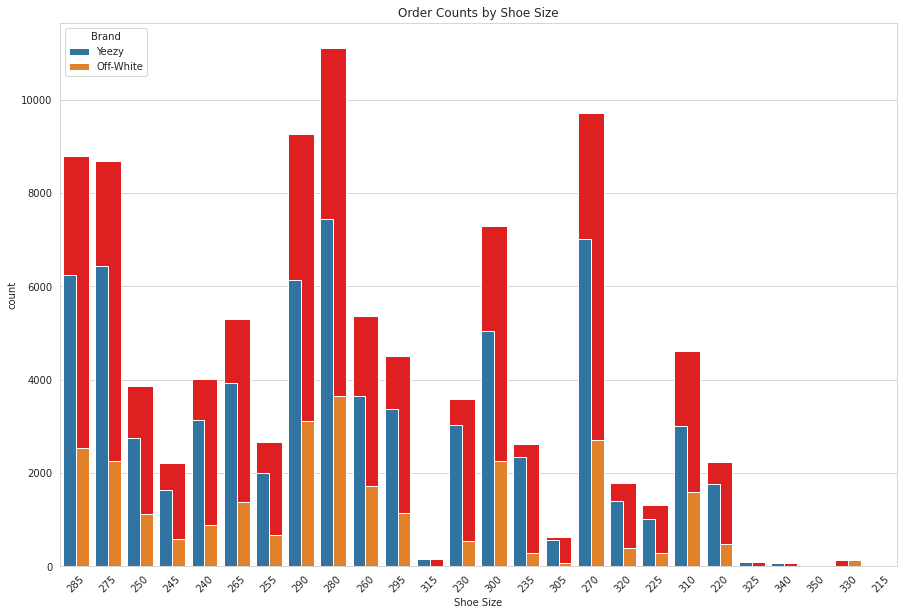

In [ ]:
# Shoe Size 분포 확인
sns.set_style('whitegrid') # 차트 배경 설정
plt.figure(figsize = (15,10))

# 그래프 겹쳐서 그리기
sns.countplot(data = df, x = 'Shoe Size', color = 'red') # seaborn의 countplot: 카테고리 값별로 데이터 빈도를 보는 차트
sns.countplot(data = df, x = 'Shoe Size', hue = 'Brand') # Brand 별로 Shoe Size 빈도 수 그리기
# sns.set(rc={'figure.figsize':(5,12)}) # seaborn 그래프 figsize 설정
plt.title('Order Counts by Shoe Size')
plt.xticks(rotation = 45) # x 레이블 회전
plt.show()

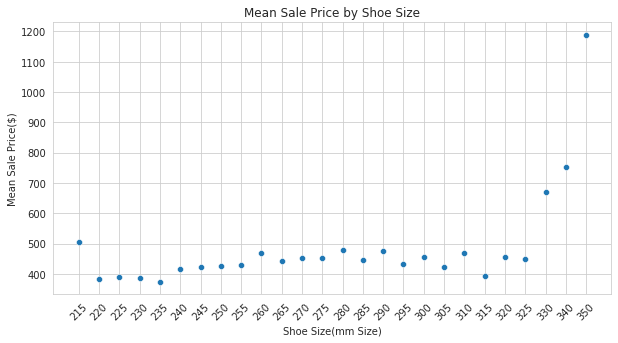

In [ ]:
# Shoe Size 별 평균 Sale Price 확인
temp_idx = df.groupby(df['Shoe Size']).mean().sort_values(by = 'Shoe Size')['Sale Price'].index
temp_value = df.groupby(df['Shoe Size']).mean().sort_values(by = 'Shoe Size')['Sale Price'].values

# Scatter Plot
plt.figure(figsize = (10,5))
sns.scatterplot(x = temp_idx, y = temp_value)
plt.xlabel('Shoe Size(mm Size)')
plt.ylabel('Mean Sale Price($)')
plt.xticks(rotation = 45)
plt.title('Mean Sale Price by Shoe Size')
plt.show()

## Buyer Region 별로 Brand 등 분포 확인

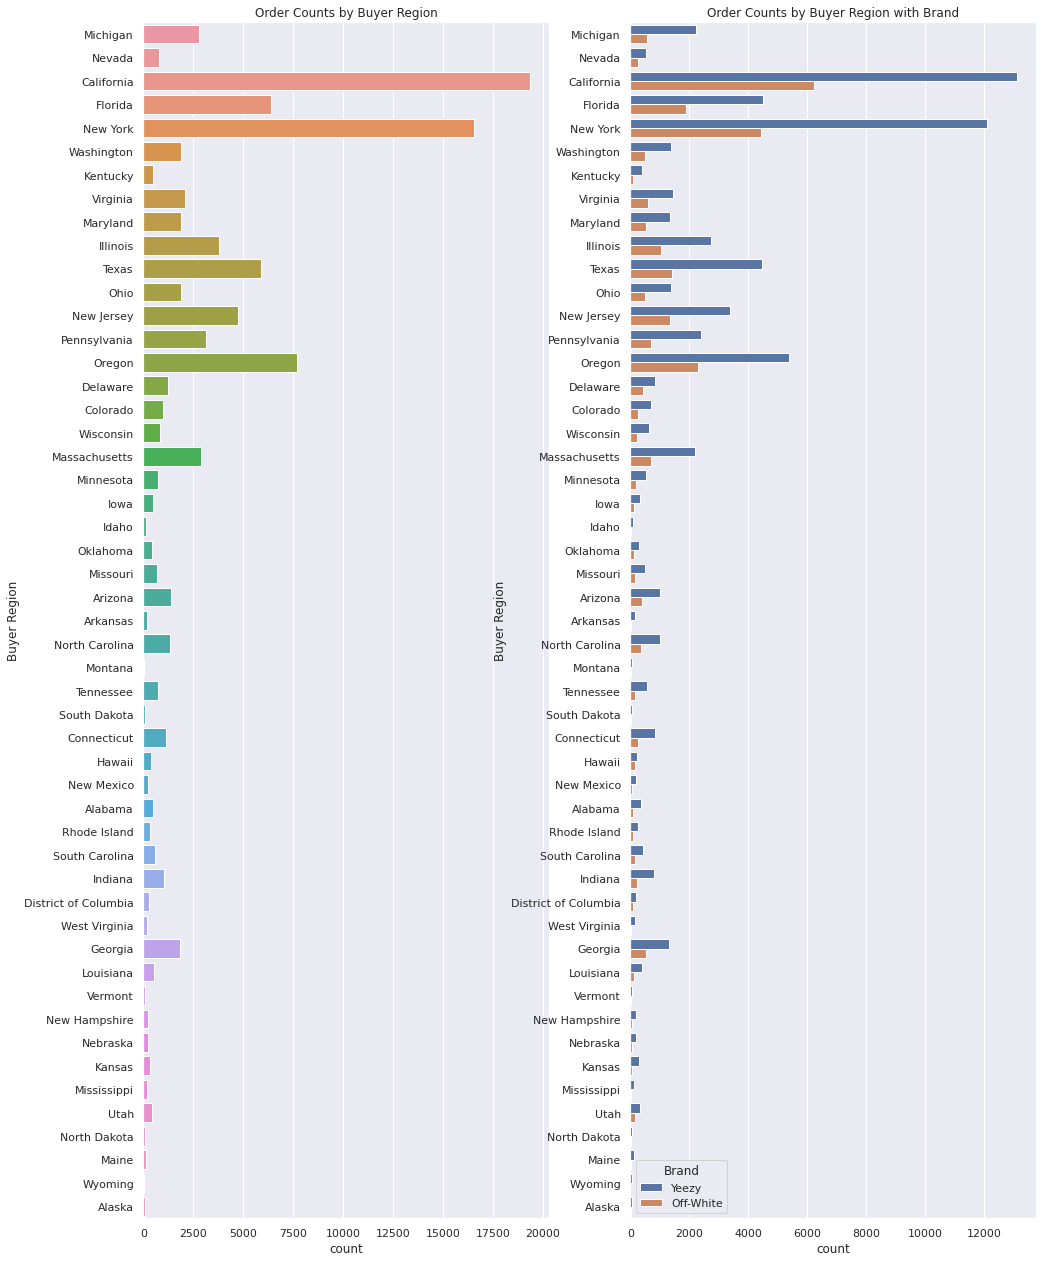

In [ ]:
# Buyer Region 분포 및 Brand 별 Buyer Region 분포 확인

# 여러 그래프 그리기 (matplotlib의 subplots 활용)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16,22))

sns.countplot(ax = axes[0], y = df['Buyer Region']) # 가로로 그래프 그리기
sns.countplot(ax = axes[1], data = df, y = 'Buyer Region', hue = 'Brand') # Brand 별 Buyer Region 분포 확인
axes[0].set_title('Order Counts by Buyer Region')  # Subplot에 title 설정
axes[1].set_title('Order Counts by Buyer Region with Brand')

plt.show()

## 스니커즈 브랜드 별 데이터 개수(거래 횟수) 확인

In [ ]:
df['Brand'].value_counts() # 스니커즈 브랜드 별 데이터 개수(거래 횟수) 확인
# 거래 횟수가 많다고 인기가 많다고 할 수 있는가?
# 확신 불가능. Because, 신발 모델 별로 출시 재고 자체가 적다면 거래 횟수가 적을 수 있다.

 Yeezy       72162
Off-White    27794
Name: Brand, dtype: int64

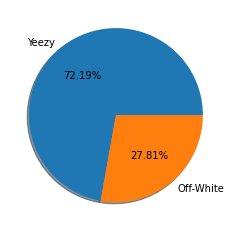

In [ ]:
# 파이 차트 이용한 시각화
plt.pie([df.Brand.value_counts()[0]/df.Brand.value_counts().sum(),df.Brand.value_counts()[1]/df.Brand.value_counts().sum()], labels = ["Yeezy","Off-White"], autopct = '%.2f%%', shadow = True)
plt.show()

## 스니커즈 종류 별 데이터 개수(거래 횟수) 확인

In [ ]:
df['Sneaker Name'].nunique() # 스니커즈 종류 개수 확인

50

In [ ]:
df['Sneaker Name'].value_counts() # 스니커즈 종류 별 데이터 개수(거래 횟수) 확인

adidas-Yeezy-Boost-350-V2-Butter                     11423
Adidas-Yeezy-Boost-350-V2-Beluga-2pt0                10395
Adidas-Yeezy-Boost-350-V2-Zebra                      10110
Adidas-Yeezy-Boost-350-V2-Blue-Tint                   9297
Adidas-Yeezy-Boost-350-V2-Cream-White                 9097
Adidas-Yeezy-Boost-350-V2-Sesame                      5553
adidas-Yeezy-Boost-350-V2-Static                      4983
Adidas-Yeezy-Boost-350-V2-Semi-Frozen-Yellow          4854
Air-Jordan-1-Retro-High-Off-White-University-Blue     4635
adidas-Yeezy-Boost-350-V2-Static-Reflective           3184
Nike-Air-Presto-Off-White-Black-2018                  1884
Nike-Air-Presto-Off-White-White-2018                  1883
Nike-Air-VaporMax-Off-White-2018                      1591
Nike-Blazer-Mid-Off-White-All-Hallows-Eve             1435
Nike-Blazer-Mid-Off-White-Grim-Reaper                 1398
Nike-Zoom-Fly-Off-White-Pink                          1359
Nike-Air-VaporMax-Off-White-Black                     13

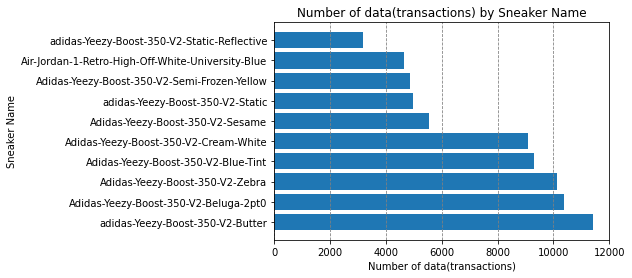

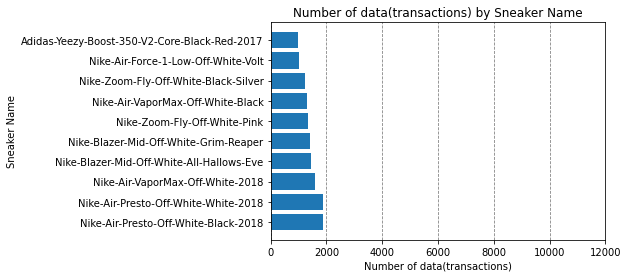

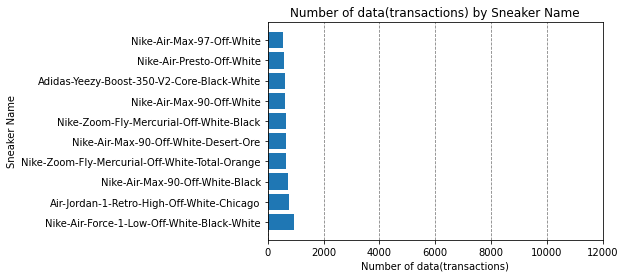

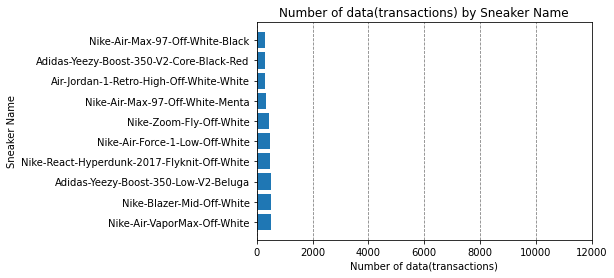

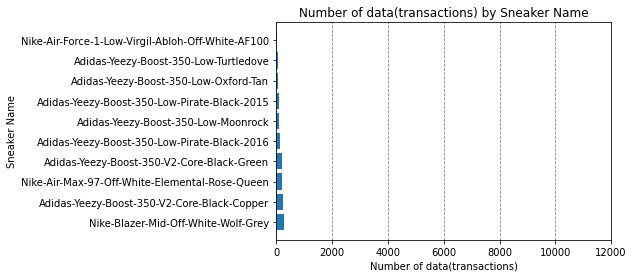

In [ ]:
# 막대 그래프 이용한 시각화
# Sneaker Name이 50개라서 한 Figure에 다 표시하면 보기 어려워서 10개씩 끊어서 시각화함.
for i in range(5):  
  plt.barh(df['Sneaker Name'].value_counts().index.tolist()[10*i:10*(i+1)], df['Sneaker Name'].value_counts().values.tolist()[10*i:10*(i+1)])   # plt.barh: 옆으로 누운 막대 그래프 (plt.bar: 세로 막대 그래프)
  plt.title('Number of data(transactions) by Sneaker Name')
  plt.xlabel('Number of data(transactions)', fontsize = 10)
  plt.ylabel('Sneaker Name', fontsize = 10)
  plt.xlim(0, 12000) # 그래프 x축 범위 지정
  plt.grid(True, axis = 'x', color = 'gray', linestyle = 'dashed')  # 보조선 추가
  plt.show()

## 스니커즈 종류 별 리셀 가격 변화 확인 (진행 중)

In [ ]:
df.sample(3)  # 랜덤으로 3개의 데이터 보기

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
30170,2018-06-17,Yeezy,Adidas-Yeezy-Boost-350-Low-Oxford-Tan,1100.0,200,2015-12-29,11.0,Colorado
59704,2018-11-13,Yeezy,Adidas-Yeezy-Boost-350-V2-Beluga-2pt0,390.0,220,2017-11-25,5.5,New York
8876,2017-12-14,Yeezy,Adidas-Yeezy-Boost-350-V2-Beluga-2pt0,340.0,220,2017-11-25,6.0,Texas


In [ ]:
from scipy. stats import mode  # 최빈값 구하기 위해

# Brand 별 Retail Price의 최소값, 최빈값 with Count, 최대값 / Sale Price의 최소값, 평균값, 최대값 구하기
df[['Retail Price','Sale Price']].groupby(df['Brand']).aggregate({'Retail Price':[min, mode, max],'Sale Price':[min, np.mean, max]})

Retail Price                        Sale Price                    
                   min              mode  max        min        mean     max
Brand                                                                       
Off-White          130   ([190], [7095])  250      203.0  671.481226  4050.0
Yeezy              200  ([220], [71707])  220      186.0  360.032625  2300.0

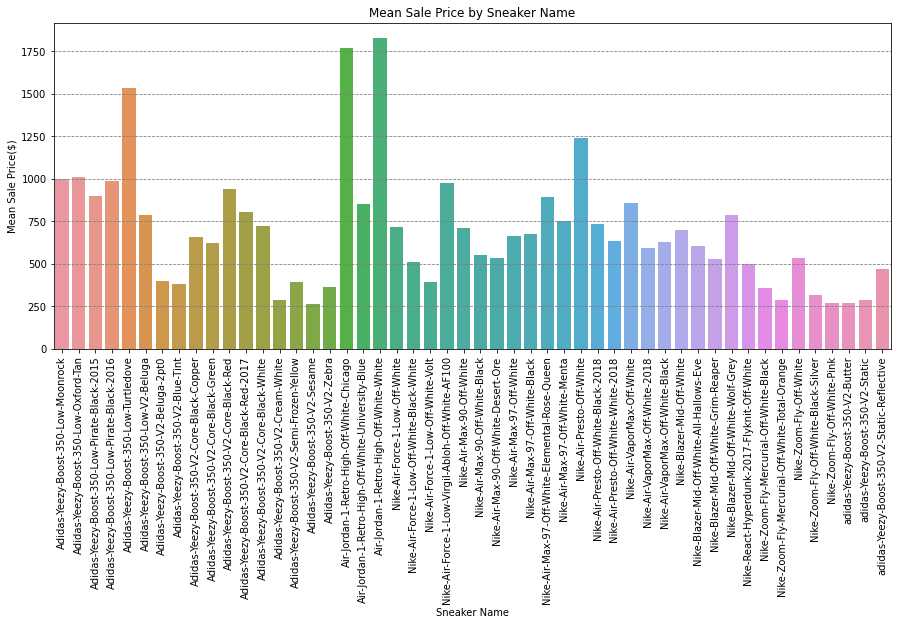

In [ ]:
# Sneaker Name 별 평균 Sale Price
sn_mean = df['Sale Price'].groupby(df['Sneaker Name']).mean()

plt.figure(figsize = (15,6))
chart = sns.barplot(x = sn_mean.index, y = sn_mean)  # seaborn을 이용한 막대 그래프 그리기
chart.set_title("Mean Sale Price by Sneaker Name")
plt.ylabel("Mean Sale Price($)")
plt.grid(True, axis = 'y', color = 'gray', linestyle = 'dashed')  # 보조선 추가
chart.set_xticklabels(chart.get_xticklabels(), rotation = 90)
plt.show()

In [ ]:
# 50개의 Sneaker Name 별로 Data Avg Sale Price 추세선을 그릴까,,,?